In [295]:
import numpy as np
import pandas as pd

In [296]:
import operator

In [297]:
import xgboost as xgb

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [299]:
# deactivate false positive warning
pd.options.mode.chained_assignment = None

# training data

In [323]:
df_all = pd.read_csv('/tmp/df_all.csv')

In [324]:
num_train = 74008

In [325]:
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
df_train.relevance.value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
Name: relevance, dtype: int64

In [326]:
df_train.columns

Index(['Unnamed: 0', 'id', 'product_title', 'product_uid', 'relevance',
       'search_term', 'product_description', 'attr_count', 'attr_texts',
       'brand', 'owl_search_term', 'owl_product_title',
       'owl_product_description', 'owl_brand', 'owl_product_info',
       'owl_len_of_query', 'owl_len_of_title', 'owl_len_of_description',
       'owl_len_of_brand', 'owl_query_in_title', 'owl_query_in_description',
       'owl_query_last_word_in_title', 'owl_query_last_word_in_description',
       'owl_word_in_title', 'owl_word_in_description', 'owl_ratio_title',
       'owl_ratio_description', 'owl_attr', 'owl_word_in_brand',
       'owl_ratio_brand', 'owl_brand_feature', 'owl_search_term_feature',
       'len_of_query', 'len_of_title', 'twq', 'query_in_title',
       'all_text_len_char', 'all_text_len_word', 'all_text_len_ratio',
       'search_text_len_char', 'search_text_len_word', 'search_text_len_ratio',
       'brand_text_len_char', 'brand_text_len_word', 'brand_text_len_ratio',


In [327]:
numerical_features = []
with open('/tmp/numerical', 'r') as f:
    for line in f:
        numerical_features.append(line.rstrip())

In [328]:
categorial_features = []
with open('/tmp/categorial', 'r') as f:
    for line in f:
        categorial_features.append(line.rstrip())

In [329]:
categorial_features, numerical_features

(['product_uid',
  'owl_len_of_brand',
  'title_text_len_char',
  'owl_query_in_title',
  'owl_brand_feature',
  'owl_query_in_description',
  'product_freq',
  'brand_text_len_word',
  'all_text_len_word',
  'twq',
  'query_id',
  'brand_text_len_char',
  'attr_text_len_word',
  'owl_search_term_feature',
  'len_of_title',
  'owl_query_last_word_in_description',
  'owl_word_in_title',
  'owl_len_of_query',
  'owl_word_in_brand',
  'search_text_len_char',
  'owl_query_last_word_in_title',
  'color_id',
  'owl_len_of_title',
  'owl_len_of_description',
  'desc_text_len_char',
  'search_text_len_word',
  'all_text_len_char',
  'title_text_len_word',
  'desc_text_len_word',
  'query_in_title',
  'len_of_query',
  'attr_text_len_char',
  'owl_word_in_description'],
 ['unigram_attributes',
  'unigram_description',
  'jaccard_search_attr',
  'unigram_title',
  'jaccard_search_title',
  'ngram_all',
  'ngram_title',
  'owl_unigram_all',
  'attr_text_len_ratio',
  'jaccard_search_brand',
  'un

In [307]:
df_test.shape

(166693, 82)

In [308]:
'cosine_ngram_title_similarity' in df_all.columns

False

# Transformers

In [187]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [275]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self
    
class ColumnSelector(EmptyFitMixin, BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        if columns is None:
            columns = [        
                'owl_title_cosine_similarity',
                'all_text_len_ratio',
                'owl_desc_cosine_similarity',
                'title_cosine_similarity',
                'all_text_len_char',
                'all_cosine_similarity',
                'cosine_ngram_title_similarity',
                'title_text_len_ratio',
                'cosine_desc_attr_golden',
                'cosine_ngram_alltext_similarity',
                'cosine_title_all_golden',
                'desc_text_len_ratio',
                'attr_cosine_similarity',
                'jaccard_search_desc',
                'desc_cosine_similarity',
                'title_text_len_char',
                'search_text_len_ratio',
                'desc_text_len_char',
                'attr_text_len_char',
                'owl_brand_feature',
                'jaccard_search_attr',
                'attr_count',
                'jaccard_search_title',
                'len_of_title',
                'search_text_len_char',
                'all_text_len_word',
                'desc_text_len_word',
                'product_freq',
                'owl_search_term_feature',
                'attr_text_len_word',
                'brand_text_len_char',
                'owl_len_of_description',
                'brand_text_len_ratio',
                'owl_len_of_title',
                'owl_ratio_title',
                'owl_ratio_description',
                'len_of_query',
                'query_in_title',
                'owl_word_in_title',
                'owl_word_in_description',
                'owl_len_of_query',
                'jaccard_search_brand',
                'owl_ratio_brand',
                'brand_text_len_word',
                'owl_query_last_word_in_description',
                'owl_query_last_word_in_title',
                'owl_query_in_description',
                'owl_len_of_brand',
                'owl_word_in_brand',
                'twq',
                'owl_query_in_title',
            ]
        self.columns = columns

    def transform(self, data):
        return data[self.columns].values

In [189]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [190]:
class cust_txt_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key].apply(str)

# Scorer

In [191]:
from sklearn.metrics import mean_squared_error, make_scorer

def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

In [192]:
RMSE = make_scorer(fmean_squared_error, greater_is_better=False)

# Models

In [193]:
class ClippedMixin:
    def predict(self, X):
        predictions = super().predict(X)
        return np.clip(predictions, 1, 3)

In [340]:
from sklearn.ensemble import RandomForestRegressor

class ClippedRF(ClippedMixin, RandomForestRegressor):
    pass

#rfr = RandomForestRegressor(n_estimators=500, max_features=10, max_depth=20, n_jobs=-1, random_state=2016, verbose=1)
#rfr = ClippedRF(n_estimators=500, max_features=10, max_depth=20, n_jobs=-1, random_state=2016, verbose=0)
rfr = RandomForestRegressor(n_estimators=15000, n_jobs=-1, min_samples_split=3, random_state=2016)

In [195]:
from sklearn.ensemble import ExtraTreesRegressor

class ClippedETR(ClippedMixin, RandomForestRegressor):
    pass

etr = ClippedETR(n_estimators=100, random_state=0)

In [196]:
from sklearn.linear_model import LinearRegression

class ClippedLR(ClippedMixin, LinearRegression):
    pass

#lrm = LinearRegression(normalize=True)
lrm = ClippedLR(normalize=True)

In [338]:
from xgboost import XGBRegressor
#xgr = XGBRegressor(n_estimators=100, max_depth=10)

class ClippedXGB(ClippedMixin, XGBRegressor):
    pass

#xgr = XGBRegressor(n_estimators=100, max_depth=6)
#xgr = ClippedXGB(n_estimators=100, max_depth=10, learning_rate=0.05,
#                 min_child_weight=1.5, colsample_bytree=0.5)
xgr = ClippedXGB(n_estimators=100, max_depth=10, learning_rate=0.05,
                 min_child_weight=1.5, colsample_bytree=0.5)

In [198]:
from sklearn.linear_model import Ridge
rdg = Ridge(alpha=0.1)

In [199]:
from sklearn.linear_model import Lasso
lso = Lasso(alpha=0.2)

In [200]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
             fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
             loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
             random_state=None, shuffle=True, verbose=0, warm_start=False)

In [201]:
class Ensemble:
    def __init__(self, clfs):
        self.clfs = clfs
        self.sum_weights = float(sum([w for c, w in self.clfs]))
        
    def fit(self, X, y):
        for clf, weight in self.clfs:
            clf.fit(X, y)
    
    def predict(self, X):
        result = np.zeros(X.shape[0])
        for clf, weight in self.clfs:
            prediction = clf.predict(X)
            result += weight * prediction
        return result / self.sum_weights

In [202]:
clfs = (
    (xgr, 10.0),
    (lrm, 1.0),
    (rfr, 10.0),
)
ens = Ensemble(clfs)

In [203]:
import os

In [204]:
import subprocess

In [205]:
class VowpalWabbit:
    def __init__(self, numerical, categorial):
        self.numerical = list(numerical)
        self.categorial = list(categorial)
        self.numerical.extend(categorial)
        
    def set_paths(self, fold):
        self.model_path = '/tmp/vw.model.{}'.format(fold)
        self.cache_path = '/tmp/vw.cache.{}'.format(fold)
        self.train_path = '/tmp/vw.train.csv.{}'.format(fold)
        self.test_path = '/tmp/vw.test.csv.{}'.format(fold)
        self.pred_path = '/tmp/vw.predictions.csv.{}'.format(fold)

    def df_to_vw(self, df, path, numerical, categorial):
        with open(path, 'w') as f:
            for _, row in df.iterrows():
                numerical_features = []
                for i, name in enumerate(numerical, 1):
                    val = row[name]
                    if val > 0:
                        numerical_features.append("I{}:{}".format(i, str(float(val))))
                categorial_features = []
                for i, name in enumerate(categorial):
                    val = str(row[name])
                    categorial_features.append("{}_{}".format(i, val))
                #search_term = row.search_term.replace(':', '')
                search_term = row.owl_search_term.replace(':', '')
                #product_title = row.product_title.replace(':', '')
                product_title = row.owl_product_title.replace(':', '')
                f.write( "{} '{} |i {} |c {} |s {} |t {}\n".format(
                    row.relevance, _, ' '.join(numerical_features),
                    ' '.join(categorial_features), search_term, product_title))
                #f.write( "{} '{} |i {} |s {} |t {}\n".format(
                #    row.relevance, _, ' '.join(numerical_features),
                #    ' '.join(categorial_features), search_term,
                #    product_title))
                #if _ > 1000:
                #    break

    def fit(self, train, y, fold):
        self.set_paths(fold)
        if not os.path.exists(self.train_path):
            self.df_to_vw(train, self.train_path, self.numerical, self.categorial)
        #args = ['vw', '-q', 'ii', '--passes',  '20', '--cache_file',
        #        '{}'.format(self.cache_path), '--ngram', '2', '-l',  '0.2', '-b',  '26',
        #        self.train_path, "-f", self.model_path] # 0.4794139395931289
        #args = ['vw', '--passes',  '20', '--cache_file',
        #        '{}'.format(self.cache_path), '--ngram', '2', '-l',  '0.2', '-b',  '26',
        #        self.train_path, "-f", self.model_path] # 0.48079364856949125
        #args = ['vw', '--passes',  '20', '--cache_file',
        #        '{}'.format(self.cache_path), '-l',  '0.2', '-b',  '26',
        #        self.train_path, "-f", self.model_path] # 0.4808270703468825
        #args = ['vw', '--passes',  '20', '--cache_file',
        #        '{}'.format(self.cache_path), '-l',  '0.0125', '-b',  '26',
        #        self.train_path, "-f", self.model_path] # 0.4644757402628758
        #args = ['vw', '-q', 'st', '--ngram', '2', '--passes',  '20', '--cache_file',
        #        '{}'.format(self.cache_path), '-l',  '0.0125', '-b',  '26',
        #        self.train_path, "-f", self.model_path] # 0.4681503483301988
        #args = ['vw', '-q', 'ci', '--ngram', '2', '--passes',  '20', '--cache_file',
        #        '{}'.format(self.cache_path), '-l',  '0.0125', '-b',  '26',
        #        self.train_path, "-f", self.model_path] # 0.4636858894216699
        args = ['vw', '--ngram', '2', '--passes',  '20', '--cache_file',
                '{}'.format(self.cache_path), '-l',  '0.0125', '-b',  '26',
                self.train_path, "-f", self.model_path] # 0.4636858894216699


        #print(' '.join(args))
        subprocess.check_call(args)
        
    def predict(self, test, fold):
        self.set_paths(fold)
        if not os.path.exists(self.test_path):
            self.df_to_vw(test, self.test_path, self.numerical, self.categorial)
        args = ["vw", self.test_path, "-t", "-i", self.model_path, "-p", self.pred_path]
        subprocess.check_call(args)
        predictions = []
        with open(self.pred_path, "rb") as f:
            for line in f:
                predictions.append(float(line.split()[0]))
        return np.array(predictions)

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10, random_state=2016)

In [207]:
#numerical_features

# Grid Search

In [208]:
from sklearn import grid_search
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [342]:
clf = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('categorial',  ColumnSelector(columns=categorial_features)),
            ('numerical', ColumnSelector(columns=numerical_features)),
#            ('txt1', Pipeline([
#                ('s1', cust_txt_col(key='owl_search_term')),
#                ('tfidf1', tfidf),
#                ('tsvd1', tsvd)
#            ])),
            ('txt2', Pipeline([
                ('s2', cust_txt_col(key='owl_product_title')),
                ('tfidf2', tfidf),
                ('tsvd2', tsvd)
            ])),
#            ('txt3', Pipeline([
#                ('s3', cust_txt_col(key='owl_product_description')),
#                ('tfidf3', tfidf),
#                ('tsvd3', tsvd)
#            ])),
#            ('txt4', Pipeline([
#                ('s4', cust_txt_col(key='owl_brand')),
#                ('tfidf4', tfidf),
#                ('tsvd4', tsvd)
#            ]))
        ],
        transformer_weights = {
            'categorial': 1.0,
            'numerical': 1.0,
            #'txt1': 0.5,
            'txt2': 0.1,
            #'txt3': 0.0,
            #'txt4': 0.5
        },
    #n_jobs = -1
    )), 
    ('rfr', rfr)]
    #('lrm', lrm)]
    #('xgr', xgr)]
    #('etr', etr)]
    #('ens', ens)]
    #('rdg', rdg)]
    #('lso', lso)]
    #('sgd', sgd)]
)

In [139]:
from sklearn.cross_validation import StratifiedKFold

In [21]:
%%time
param_grid = {}
#param_grid = {'rfr__max_features': [10, 20], 'rfr__max_depth': [10, 20]}
#param_grid = {'xgr__n_estimators': [95, 100, 105], 'xgr__max_depth': [8, 9, 10],
#              'xgr__learning_rate': [0.05, 0.1, 0.15], 'xgr__min_child_weight': [0.5, 1, 1.5],
#              'xgr__colsample_bytree': [0.3, 0.5, 1.0]}
#param_grid = {'xgr__n_estimators': [95, 100], 'xgr__max_depth': [9, 10],
#              'xgr__learning_rate': [0.05, 0.1, 0.15], 'xgr__min_child_weight': [0.5, 1, 1.5],
#              'xgr__colsample_bytree': [0.3, 0.5, 1.0]}
model = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, refit=False,
                                 n_jobs=1, cv=StratifiedKFold(y_train, n_folds=5, shuffle=True),
                                 verbose=20, scoring=RMSE)
model.fit(df_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ...................................... , score=-0.462972 -   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    4.4s


[CV] ...................................... , score=-0.462701 -   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    8.5s


[CV] ...................................... , score=-0.464938 -   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:   13.0s


[CV] ...................................... , score=-0.462192 -   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   17.4s


[CV] ...................................... , score=-0.463932 -   4.5s
CPU times: user 1min 23s, sys: 7.48 s, total: 1min 31s
Wall time: 22 s


[Parallel(n_jobs=1)]: Done   5 tasks       | elapsed:   21.9s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.9s finished


In [399]:
print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)
print(model.best_score_ + 0.47003199274)

Best parameters found by grid search:


AttributeError: 'ClippedXGB' object has no attribute 'best_params_'

In [27]:
print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)
print(model.best_score_ + 0.47003199274)

Best parameters found by grid search:
{}
Best CV score:
-0.461086204419
0.00894578832114


In [22]:
print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)
print(model.best_score_ + 0.47003199274)

Best parameters found by grid search:
{}
Best CV score:
-0.463347035809
0.00668495693136


In [23]:
print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)
print(model.best_score_ + 0.47003199274)

Best parameters found by grid search:
{}
Best CV score:
-0.476459511834
-0.00642751909417


In [78]:
print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)
print(model.best_score_ + 0.47003199274)

Best parameters found by grid search:
{}
Best CV score:
-0.478250176914
-0.00821818417378


In [119]:
#dir(model)

In [27]:
model.scoring

make_scorer(fmean_squared_error, greater_is_better=False)

# error

In [88]:
df_train['error'] = 0.0

In [89]:
df_train['pred'] = 0.0

In [169]:
def evaluate(clf):
    scores = []
    errors = []
    cross_validation = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=2016)
    for fold, (train, test) in enumerate(cross_validation):
        clf.fit(df_train.ix[train], y_train[train], fold)
        pred = clf.predict(df_train.ix[test], fold)
        score = mean_squared_error(y_train[test], pred) ** 0.5
        print(score)
        scores.append(score)
        tmp_errors = []
        for p, t, i in zip(pred, y_train[test], df_train.index[test]):
            err = (t - p) ** 2
            tmp_errors.append(err)
            df_train.set_value(i, 'error', err)
            df_train.set_value(i, 'pred', p)
        errors.extend(tmp_errors)
        #print(tmp_errors)
        tmp_errors = np.array(tmp_errors)
        #print('manual: {}'.format(np.average(tmp_errors) ** 0.5))
    print('all: {}'.format(sum(scores)/float(len(scores))))
    #print('manual all: {}'.format(np.average(errors) ** 0.5))

In [141]:
evaluate(VowpalWabbit(numerical_features, categorial_features))

0.464862144528
0.464243730374
0.462674146201
0.462798346068
0.463851079938
all: 0.4636858894216699


In [94]:
evaluate(VowpalWabbit(numerical_features, categorial_features))

0.470301309736
0.469439699798
0.468414296957
0.468949903216
0.47025705797
all: 0.4694724535353464


In [97]:
#VowpalWabbit(numerical_features, categorial_features).my_numerical[60]

'product_uid'

In [111]:
evaluate(VowpalWabbit(numerical_features, categorial_features))

61
0.468971271531
0.467745825465
0.46599973705
0.465904643172
0.469638935574
all: 0.46765208255844987


In [173]:
evaluate(VowpalWabbit(numerical_features, categorial_features))

0.469048584102
0.467683583215
0.465849245228
0.465955907432
0.469314953136
all: 0.4675704546223761


In [212]:
def evaluate(clf):
    scores = []
    errors = []
    #X = ColumnSelector().transform(df_train)
    for train, test in StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=2016):
        clf.fit(df_train.ix[train], y_train[train])
        pred = clf.predict(df_train.ix[test])
        score = mean_squared_error(y_train[test], pred) ** 0.5
        print(score)
        scores.append(score)
        tmp_errors = []
        for p, t, i in zip(pred, y_train[test], df_train.index[test]):
            err = (t - p) ** 2
            tmp_errors.append(err)
            df_train.set_value(i, 'error', err)
            df_train.set_value(i, 'pred', p)
        errors.extend(tmp_errors)
        #print(tmp_errors)
        tmp_errors = np.array(tmp_errors)
        #print('manual: {}'.format(np.average(tmp_errors) ** 0.5))
    print('all: {}'.format(sum(scores)/float(len(scores))))
    #print('manual all: {}'.format(np.average(errors) ** 0.5))

In [407]:
%%time
evaluate(clf)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished


0.455789970049


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


0.452827168108


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


0.453986514522


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.4s finished


0.452160692053


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.4s finished


0.454785990063
all: 0.4539100669589998
CPU times: user 26min 44s, sys: 20.2 s, total: 27min 4s
Wall time: 4min 31s


In [256]:
%%time
clf.fit(df_train, y_train)

CPU times: user 6min 9s, sys: 4.94 s, total: 6min 14s
Wall time: 54.6 s


Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('categorial', ColumnSelector(columns=['owl_len_of_query', 'owl_len_of_title', 'owl_len_of_description', 'owl_len_of_brand', 'owl_query_in_title', 'owl_query_in_description', 'owl_query_last_word_in_title', 'owl_query_last_word_in_desc...erical': 1.0, 'categorial': 1.0, 'txt2': 0.1})), ('ens', <__main__.Ensemble object at 0x178bc7e10>)])

In [255]:
%%time
evaluate(clf)

0.455068801143
0.452087132302
0.452411973723
0.450911096285
0.45386921352
all: 0.452869643394563
CPU times: user 25min 54s, sys: 22.4 s, total: 26min 17s
Wall time: 3min 48s


In [141]:
%%time
evaluate(clf)

0.456991271871
0.453615659299
0.456016285529
0.453421421376
0.455816676503
all: 0.45517226291563767
CPU times: user 3min 29s, sys: 13.7 s, total: 3min 43s
Wall time: 49.3 s


In [143]:
%%time
evaluate(clf)

0.4561507338
0.452509987497
0.452895004897
0.451215705626
0.454167836004
all: 0.45338785356484984
CPU times: user 22min 28s, sys: 10.2 s, total: 22min 38s
Wall time: 3min 8s


In [161]:
%%time
evaluate(clf)

0.45519468154
0.452078035858
0.452711600393
0.451522311504
0.453705121136
all: 0.45304235008652294
CPU times: user 25min 58s, sys: 22.2 s, total: 26min 20s
Wall time: 3min 47s


In [213]:
%%time # xgb
evaluate(clf)

0.457508723426
0.454482839888
0.456322725939
0.453723357998
0.45625048172
all: 0.4556576257942602
CPU times: user 3min 37s, sys: 12.6 s, total: 3min 50s
Wall time: 48.1 s


In [241]:
%%time 
evaluate(clf) # xgb

0.456971240355
0.454938036809
0.454990214405
0.45360384618
0.456481803353
all: 0.45539702822039974
CPU times: user 3min 26s, sys: 12.5 s, total: 3min 38s
Wall time: 44.9 s


In [262]:
%%time 
evaluate(clf) # xgb

0.458375220791
0.455061651254
0.456011333487
0.455428618662
0.456877108265
all: 0.45635078649185157
CPU times: user 2min 53s, sys: 10.9 s, total: 3min 4s
Wall time: 34.3 s


In [294]:
%%time 
evaluate(clf) # xgb

0.457926943659
0.45492967326
0.455780817297
0.455834125689
0.456157587673
all: 0.45612582951566283
CPU times: user 3min 16s, sys: 12.1 s, total: 3min 28s
Wall time: 38.3 s


In [311]:
%%time 
evaluate(clf) # xgb

0.458048491359
0.455139045528
0.455396956703
0.455453689463
0.456883310118
all: 0.45618429863389
CPU times: user 3min 8s, sys: 11.4 s, total: 3min 20s
Wall time: 37.1 s


In [339]:
%%time 
evaluate(clf) # xgb

0.458115750596
0.455053469066
0.455055939649
0.454963514734
0.456674618075
all: 0.45597265842400175
CPU times: user 2min 58s, sys: 11.3 s, total: 3min 9s
Wall time: 36.2 s


In [222]:
%%time
evaluate(clf) # rfr

0.455739469578
0.451923920684
0.452477651447
0.45074818665
0.454370873657
all: 0.4530520204032504
CPU times: user 22min 24s, sys: 11 s, total: 22min 35s
Wall time: 3min 9s


In [250]:
%%time
evaluate(clf) # rfr

0.455999388801
0.451890178362
0.452489251703
0.450677179829
0.454074331344
all: 0.4530260660076807
CPU times: user 22min, sys: 9.67 s, total: 22min 10s
Wall time: 3min 1s


In [318]:
%%time
evaluate(clf) # rfr

0.457115529755
0.453133052223
0.453167836232
0.452219991768
0.45552536178
all: 0.4542323543515264
CPU times: user 19min 20s, sys: 10.1 s, total: 19min 31s
Wall time: 2min 38s


In [343]:
%%time
evaluate(clf) # rfr

KeyboardInterrupt: 

In [319]:
importances = {'feature': [], 'importance': []}
f_importances = clf.steps[-1][-1].feature_importances_
cols = ColumnSelector(columns=categorial_features).columns + \
                   ColumnSelector(columns=numerical_features).columns
for col, importance in zip(cols, f_importances):
    importances['feature'].append(col)
    importances['importance'].append(importance)
df_importance = pd.DataFrame(importances)
#df_importance = df_importance.sort_values(by='importance')

In [320]:
df_importance.sort_values(by='importance', ascending=False)

,feature,importance
54,ngram_title,0.060216
33,owl_ratio_title,0.054846
58,owl_unigram_title,0.043755
53,ngram_all,0.040311
30,product_uid,0.036195
34,owl_ratio_description,0.028579
45,unigram_title,0.027179
57,owl_unigram_all,0.024921
44,unigram_all,0.023517
48,bigram_all,0.022272


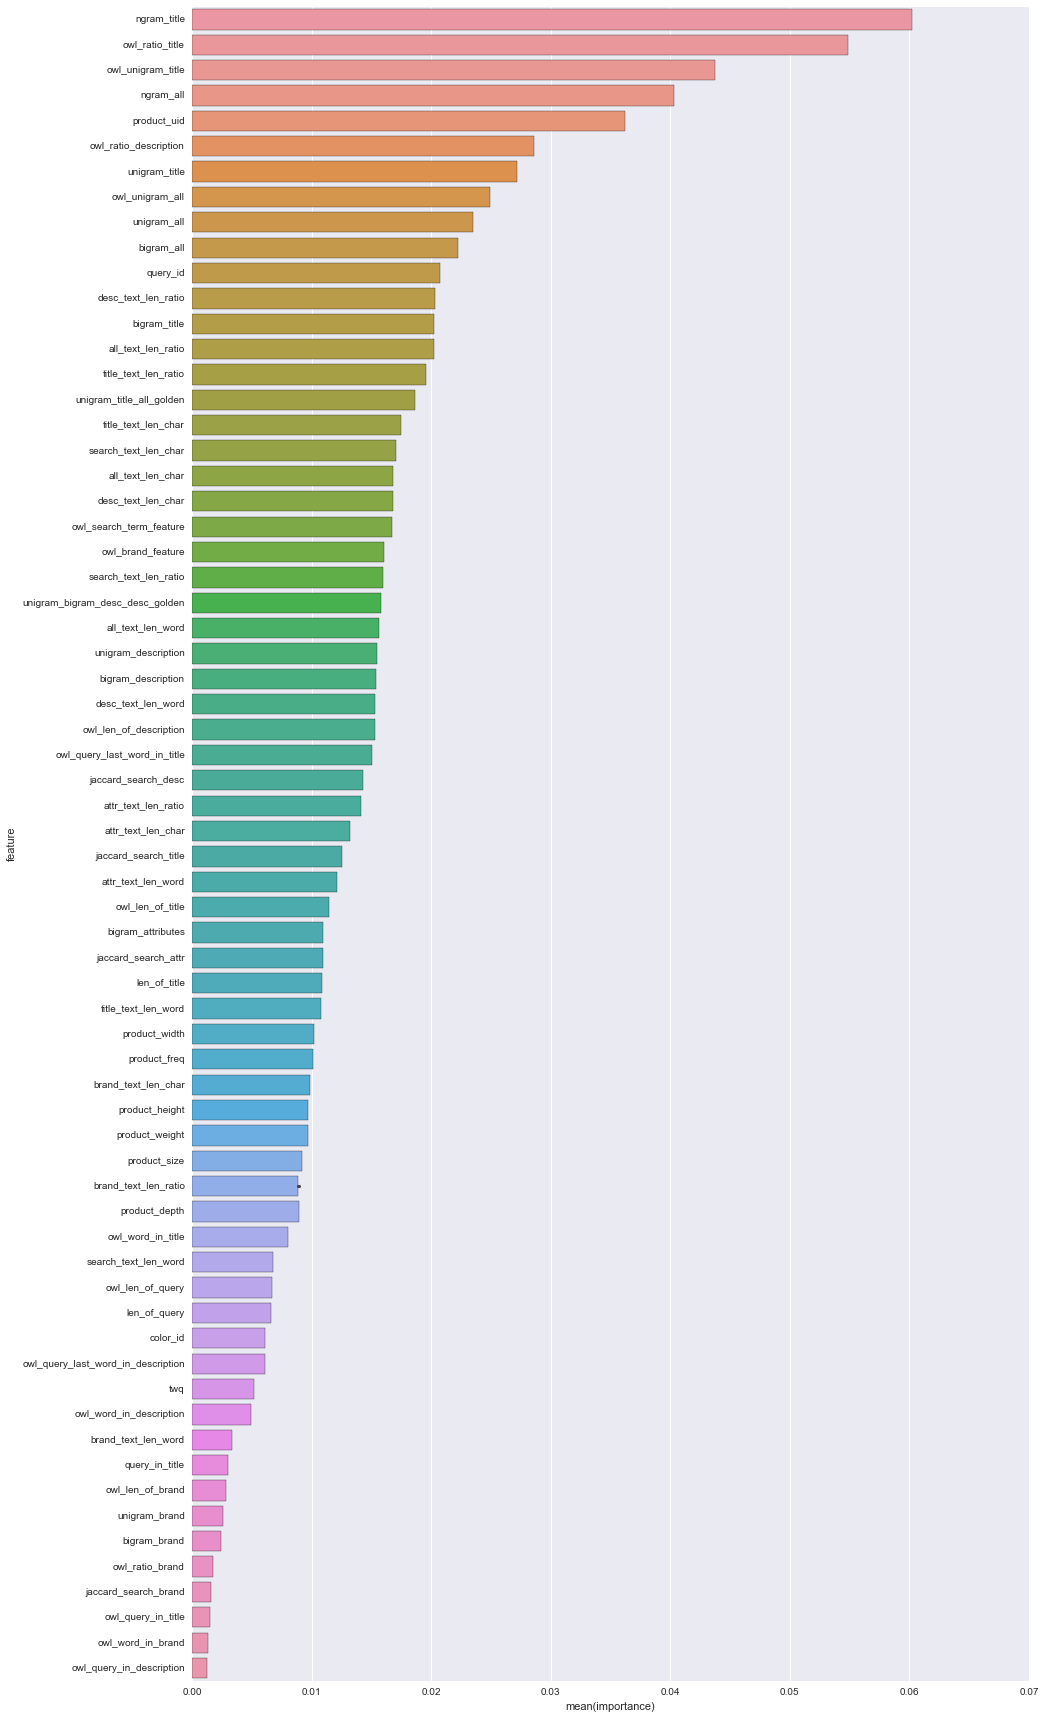

In [321]:
f, ax = plt.subplots(figsize=(15, 30))
a = sns.barplot(x='importance', y='feature', data=df_importance.sort_values(by='importance', ascending=False))

In [249]:
np.average(df_train.error) ** 0.5

0.45876852395789863

In [1]:
np.average(df_train.error)

NameError: name 'np' is not defined

In [91]:
pd.set_option('max_colwidth', 200)

In [122]:
cols = ['relevance', 'pred', 'error', 'search_term', 'product_title', 'product_description']
df_train[df_train.error > 0.5][cols].sort_values(['error'], ascending=False)

,relevance,pred,error,search_term,product_title,product_description
22585,1.00,2.770268,3.133848,topiary tree,Romano 4 ft. Boxwood Spiral Topiary Tree,Enhance your home with a Romano Boxwood Spiral Topiary Tree. This wonderful full bodied Boxwood Spiral Topiary Tree keeps its colors when all the rest lose their color and leaves. You can always l...
39506,1.00,2.762619,3.106825,rachael ray,Rachael Ray 10 qt. Covered Stockpot,"Whether you're boiling pasta, making a batch of chili or cooking grains, this large, 10 quart stockpot is just the right size. When it's not on the stovetop, its two short side handles help it tak..."
21313,1.00,2.746364,3.049789,small tree,Tree Trainer Small Self-Supporting Tree Brace,The Tree Trainer is an innovative product award winner through the American Nursery and Landscape Association. Designed as an environmentally safe product that has been engineered for durability. ...
27963,1.00,2.743893,3.041164,grape plant,Oakland Living 26 in. Metal Grape Table Plant Stand,The Oakland Living 26 in. Metal Grape Table Plant Stand offers a sturdy and beautiful place to keep plants on display. This stand is made from cast iron for durability with an antique bronze powde...
31530,1.00,2.696071,2.876657,copper faucet,BrassCraft 3/8 in. O.D. x 36 in. Copper Faucet Riser in Chrome,"BrassCraft 3/8 in. O.D. tube x 36 in. length chrome-plated copper riser for faucet installations features one-piece formed metal nosepiece with insert. Cut-to-Length for flexible fit with a clean,..."
43416,1.00,2.693520,2.868010,laminate floor tile,"Bona Stone, Tile and Laminate Floor Care System","Use the Bona Stone, Tile and Laminate Floor Care System to clean hard-surface floors in your home. The 4-piece kit includes a mop, microfiber cleaning and dusting pads and a 32 oz. spray bottle of..."
32670,1.00,2.674037,2.802400,linzer,Linzer 9 in. x 3/8 in. Medium-Density Polyester Roller Cover (6-Pack),The 9 in. x 3/8 in. Medium-Density Polyester Roller Covers (6-Pack) are for use with both oil-based and latex paints. These rollers are reusable if washed with water or mineral spirits after each ...
53368,1.00,2.635210,2.673910,mortar tools,Buffalo Tools Folding Mortar Board Stand-DISCONTINUED,"Red Snapr insulators are made from only the highest grade, high density polyethylene that results in a rugged, durable construction. They are UV-protected to resist weathering, even under the hars..."
44061,1.00,2.607376,2.583658,solar vents,Master Flow 24 VDC Replacement Motor for Solar and Dual-Powered Series Vents,The SLRM105 is the replacement motor for all Master Flow Green Machine Solar Powered Roof Vents. It can be used with Master Flow Solar and Dual-powered models. Brushless 24 VDC motor.Replaceable ...
24792,1.00,2.602719,2.568709,round beech,Zamma Beech Blocked 5/8 in. Thick x 3/4 in. Wide x 94 in. Length Laminate Quarter Round Molding,"Beech Blocked Quarter Round is used to accent the transitions from baseboard to floor surface, especially in retrofitted floors where the baseboard typically is not removed. The quarter round prov..."


In [97]:
df_train.iloc[9625]

Unnamed: 0                                                                                                                                                                                                                               9625
id                                                                                                                                                                                                                                      29899
product_title                                                                                                                                                                           Westinghouse Ceiling Fan and Light White Wall Control
product_uid                                                                                                                                                                                                                            106452
relevance                                       

In [312]:
def create_feature_map(features):
    outfile = open('/tmp/xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [313]:
create_feature_map(ColumnSelector(columns=categorial_features).columns + \
                   ColumnSelector(columns=numerical_features).columns)

In [314]:
%%time
xgb_params = {"objective": "reg:linear", "eta": 0.05, "max_depth": 10, "seed": 2016, "silent": 1,
              "n_estimators": 100, "min_child_weight": 1.5, "colsample_bytree": 0.5}
num_rounds = 1000
dtrain = xgb.DMatrix(clf.steps[0][-1].transform(df_train), label=y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

CPU times: user 7min 24s, sys: 18.9 s, total: 7min 43s
Wall time: 1min 23s


,feature,importance
0,jaccard_search_brand,0.000891
1,owl_query_in_title,0.001308
2,twq,0.001435
3,search_text_len_word,0.001550
4,owl_ratio_brand,0.001585
5,brand_text_len_word,0.002318
6,owl_word_in_brand,0.002557
7,owl_query_in_description,0.002597
8,bigram_brand,0.003462
9,owl_query_last_word_in_description,0.003598


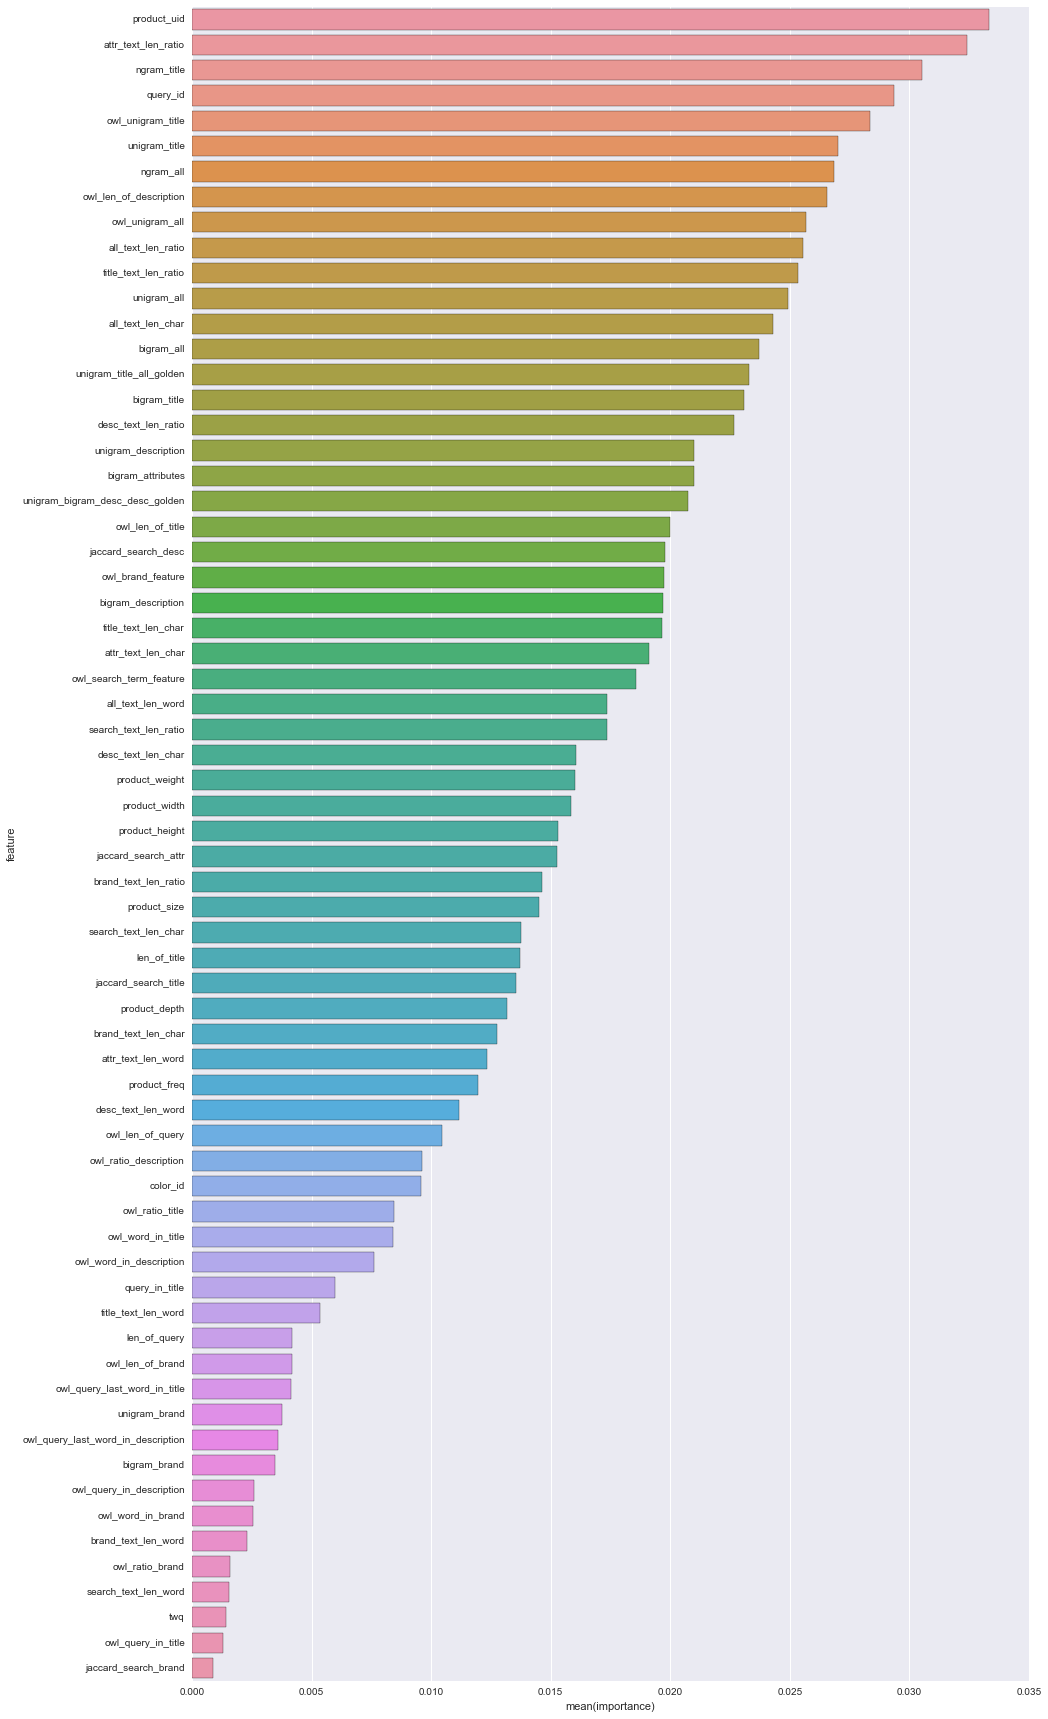

In [315]:
importance = gbdt.get_fscore(fmap='/tmp/xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_xgb_imp = pd.DataFrame(importance, columns=['feature', 'importance'])
df_xgb_imp['importance'] = df_xgb_imp['importance'] / df_xgb_imp['importance'].sum()

f, ax = plt.subplots(figsize=(15, 30))
a = sns.barplot(x='importance', y='feature', data=df_xgb_imp.sort_values(by='importance', ascending=False))

df_xgb_imp

In [316]:
for feature in df_xgb_imp.sort_values(by='importance', ascending=False).feature:
    print("'{}',".format(feature))

'product_uid',
'attr_text_len_ratio',
'ngram_title',
'query_id',
'owl_unigram_title',
'unigram_title',
'ngram_all',
'owl_len_of_description',
'owl_unigram_all',
'all_text_len_ratio',
'title_text_len_ratio',
'unigram_all',
'all_text_len_char',
'bigram_all',
'unigram_title_all_golden',
'bigram_title',
'desc_text_len_ratio',
'unigram_description',
'bigram_attributes',
'unigram_bigram_desc_desc_golden',
'owl_len_of_title',
'jaccard_search_desc',
'owl_brand_feature',
'bigram_description',
'title_text_len_char',
'attr_text_len_char',
'owl_search_term_feature',
'all_text_len_word',
'search_text_len_ratio',
'desc_text_len_char',
'product_weight',
'product_width',
'product_height',
'jaccard_search_attr',
'brand_text_len_ratio',
'product_size',
'search_text_len_char',
'len_of_title',
'jaccard_search_title',
'product_depth',
'brand_text_len_char',
'attr_text_len_word',
'product_freq',
'desc_text_len_word',
'owl_len_of_query',
'owl_ratio_description',
'color_id',
'owl_ratio_title',
'owl_word_in_ti

# Submission

In [257]:
X_test = df_test[:]

In [258]:
X_test.shape

(166693, 77)

In [259]:
y_pred = clf.predict(X_test)

In [260]:
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv', index=False)